# Survival SHAREs Evaluation

This notebook visualises some cherry-picked results from fitting SHAREs on survival datasets (`share_ph.py`). 

In [200]:
import numpy as np 
import pandas as pd 
import torch 
import matplotlib.pyplot as plt
import seaborn as sns

import os 
from pathlib import Path
from datetime import datetime

sns.set_style("whitegrid")
sns.set_palette("colorblind")
torch.cuda.is_available()

False

## 1. Rossi Data

Calibration is sensible in some high-scoring models. Lots of overfitting is evident. 

In [201]:
from datasets import Rossi, Metabric, GBSG2
from sklearn.model_selection import train_test_split

dataset = Rossi()
X, T, E = dataset.load(normalise=False)
feature_names = dataset.features

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E, test_size=0.2, random_state=42
)

In [202]:
variant = 'rossi_pll_shrink'
checkpoint_dir = Path(f'data/checkpoints/{variant}')
timestamp = max(os.listdir(checkpoint_dir), key=lambda x: datetime.strptime(x, "%Y-%m-%dT%H.%M.%S"))

In [203]:
res_df = pd.read_csv(checkpoint_dir / timestamp / "output.csv")
res_df = res_df[res_df.n_shapes != 0].sort_values(by="brier_test", ascending=True).reset_index(drop=True) # Will later rank based on training loss. Just cherry picking for now. 
res_df.head(10)

,id,equation,raw_fitness,r2,n_shapes,n_variables,loss_test,c_test,brier_test
0,75,"shape(add(div(div(X1, add(X5, X2)), shape(X3))...",7.568369,0.017988,2,5,6.717893,0.393288,0.108092
1,91,"shape(add(shape(add(add(div(shape(X1), shape(X...",7.559750,-0.041167,7,5,7.206418,0.334557,0.114724
2,50,"shape(add(X6, add(shape(X2), X0)))",6.290853,-0.005541,2,3,6.596867,0.397221,0.118163
3,374,"div(X0, shape(mul(shape(mul(add(X5, shape(X1))...",3.990288,-17.423903,3,5,4.298000,0.465915,0.118466
4,290,"shape(div(mul(mul(div(X0, add(mul(shape(X2), X...",6.408531,0.001096,4,7,6.649136,0.518878,0.118542
5,364,"div(X6, div(mul(shape(X3), X4), X1))",4.020006,-17.520124,1,4,4.328013,0.490037,0.118698
6,285,"mul(div(div(X6, X3), add(X5, shape(add(shape(m...",3.994692,-17.469509,4,7,4.305045,0.480336,0.118876
7,377,"div(X0, div(div(shape(mul(shape(mul(div(shape(...",3.990363,-17.431772,6,7,4.300516,0.485579,0.118943
8,365,"div(X0, div(div(shape(mul(add(shape(X2), shape...",3.992253,-17.442877,4,6,4.295910,0.485579,0.118961
9,333,"div(X2, div(mul(shape(X3), X4), X1))",3.988913,-17.430735,1,4,4.311660,0.494232,0.118972


In [204]:
from experiments.utils import load_share_from_checkpoint

eq = res_df.iloc[0]['equation']
id = res_df.iloc[0]['id']

esr_best = load_share_from_checkpoint(
    timestamp, eq, 
    checkpoint_dir=checkpoint_dir, 
    task='regression',
    n_features=len(feature_names), 
    equation_id=id
)
esr_best._program.feature_names = feature_names
esr_best

/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

shape(add(div(div(X1, add(X5, X2)), shape(X3)), X4))


SymbolicRegressor(categorical_variables={}, const_range=None,
                  function_set=('add', 'mul', 'div', 'shape'), generations=10,
                  metric='mse',
                  optim_dict={'alg': 'adam', 'batch_size': 2000,
                              'constructor_dict': {'activation_name': 'ELU',
                                                   'n_hidden_layers': 5,
                                                   'width': 10},
                              'device': 'cpu', 'lr': 0.01, 'max_n_epochs': 1000,
                              'num_workers_dataloader': 0, 'seed': 42,
                              'shape_class': <class 'gplearn.gplearn.model.ShapeNN'>,
                              'task': 'regression', 'tol': 0.001},
                  p_crossover=0.4, p_hoist_mutation=0.05, p_point_mutation=0.2,
                  p_point_replace=0.2, p_subtree_mutation=0.2,
                  parsimony_coefficient=0.0, population_size=500,
                  random_state=42, tournament_size=10, verbose=True)

In [ ]:
from share_survival import SymRegPH
esr_wrapped = SymRegPH(esr_best)
esr_wrapped.compute_baseline_hazards(X_train, (T_train, E_train))
surv_pred = esr_wrapped.predict_surv_df(X_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ICI =  0.1373458233381601
E50 =  0.14905805556022222


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 52 mortality'}, xlabel='Predicted probability of \nt ≤ 52 mortality', ylabel='Observed probability of \nt ≤ 52 mortality'>,
 np.float64(0.1373458233381601),
 np.float64(0.14905805556022222))

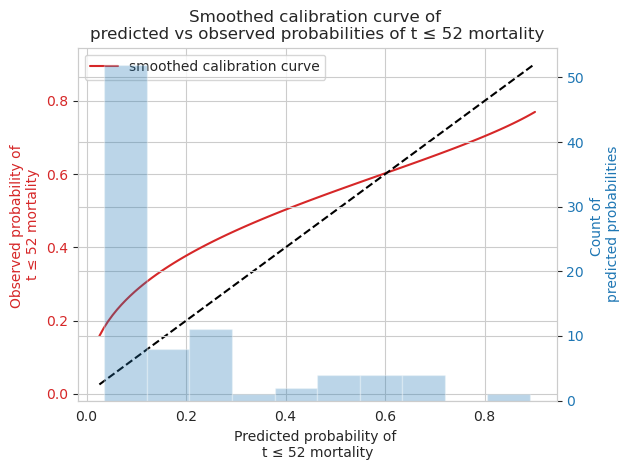

In [207]:
from plot import survival_probability_calibration

survival_probability_calibration(surv_pred, T_test, E_test, t0=Rossi().tmax)

shape(add(div(div(age, add(paro, race)), shape(wexp)), mar))


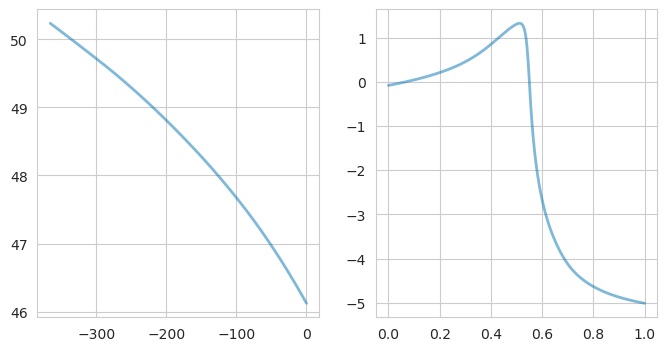

In [208]:
def shape_plot(shape, range_min, range_max):
    shape.to(torch.device('cpu')).eval()
    t = np.linspace(range_min, range_max, 1000)
    with torch.no_grad():
        y = shape(torch.from_numpy(t).float()).numpy().flatten()
    return (t, y)

n_shapes = len(esr_best._program.model.shape_functions)
ranges = esr_best.get_shape_ranges(pd.DataFrame(X_test, columns=feature_names))
print(esr_best)
fix, ax = plt.subplots(1, 2, figsize=(8, 4))
ax = ax.ravel()

for i, shape in enumerate(esr_best._program.model.shape_functions):
    t, y = shape_plot(shape, ranges[i][0], ranges[i][1])
    ax[i].plot(t, y, linewidth=2.0, alpha=0.5)


## 2. Metabric Data
Pending run. CSD3 under maintenance again. 

## 3. GBSG2 Data

Performance here is similar. Calibration is very poor. Shape functions tend to explode in range moreso than Rossi. 

In [209]:
dataset = GBSG2()

X, T, E = dataset.load(normalise=False)
feature_names = dataset.features

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(
    X, T, E, test_size=0.2, random_state=42
)

In [210]:
variant = 'gbsg2_pll_shrink'
checkpoint_dir = Path(f'data/checkpoints/{variant}')
timestamp = max(os.listdir(checkpoint_dir), key=lambda x: datetime.strptime(x, "%Y-%m-%dT%H.%M.%S"))

In [211]:
res_df = pd.read_csv(checkpoint_dir / timestamp / "output.csv")
res_df = res_df[res_df.n_shapes != 0].sort_values(by="c_test", ascending=False).reset_index(drop=True)
res_df.head(10)

,id,equation,raw_fitness,r2,n_shapes,n_variables,loss_test,c_test,brier_test
0,251,"div(shape(div(mul(mul(shape(X6), shape(X2)), s...",3.758792,-3.382978,6,5,3.610407,0.587516,0.131379
1,163,"div(X2, shape(div(X3, shape(add(X5, mul(div(sh...",3.736630,-3.384283,4,6,3.559535,0.567674,0.125549
2,299,"div(shape(div(mul(mul(shape(X6), shape(X2)), s...",3.846780,-3.382917,6,5,3.681977,0.565309,0.140433
3,268,"div(shape(div(mul(add(shape(X2), shape(add(X0,...",3.731684,-3.384130,8,8,3.556755,0.564389,0.125635
4,279,"div(shape(div(mul(mul(shape(X6), mul(add(add(s...",4.312805,-3.340742,9,8,4.159118,0.561498,0.152334
5,396,"div(shape(div(mul(mul(shape(X6), shape(X7)), s...",3.724917,-3.383571,6,5,3.584365,0.561104,0.127603
6,210,"div(shape(div(mul(mul(shape(X6), shape(X7)), s...",3.724917,-3.383571,6,5,3.584365,0.561104,0.127603
7,193,"div(shape(div(mul(mul(shape(X6), shape(X2)), s...",3.732913,-3.383959,6,5,3.559007,0.559527,0.125475
8,330,"div(shape(div(mul(shape(mul(shape(X4), X0)), s...",3.731607,-3.384133,6,5,3.556654,0.559264,0.125331
9,164,"div(shape(div(mul(mul(shape(X6), shape(X2)), s...",3.730153,-3.383639,6,5,3.575400,0.557687,0.127285


In [212]:
eq = res_df.iloc[1]['equation']
id = res_df.iloc[1]['id']

esr_best = load_share_from_checkpoint(
    timestamp, eq, 
    checkpoint_dir=checkpoint_dir, 
    task='regression',
    n_features=len(feature_names), 
    equation_id=id
)
esr_best._program.feature_names = feature_names
esr_best

div(X2, shape(div(X3, shape(add(X5, mul(div(shape(X4), shape(X0)), X1))))))


/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

SymbolicRegressor(categorical_variables={}, const_range=None,
                  function_set=('add', 'mul', 'div', 'shape'), generations=10,
                  metric='mse',
                  optim_dict={'alg': 'adam', 'batch_size': 2000,
                              'constructor_dict': {'activation_name': 'ELU',
                                                   'n_hidden_layers': 5,
                                                   'width': 10},
                              'device': 'cpu', 'lr': 0.01, 'max_n_epochs': 1000,
                              'num_workers_dataloader': 0, 'seed': 42,
                              'shape_class': <class 'gplearn.gplearn.model.ShapeNN'>,
                              'task': 'regression', 'tol': 0.001},
                  p_crossover=0.4, p_hoist_mutation=0.05, p_point_mutation=0.2,
                  p_point_replace=0.2, p_subtree_mutation=0.2,
                  parsimony_coefficient=0.0, population_size=500,
                  random_state=42, tournament_size=10, verbose=True)

In [213]:
esr_wrapped = SymRegPH(esr_best)
esr_wrapped.compute_baseline_hazards(X_train, (T_train, E_train))
surv_pred = esr_wrapped.predict_surv_df(X_test, max_duration=351)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/rds/user/sb2690/hpc-work/software/micromamba/envs/shares3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 76 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ICI =  0.044432990438448
E50 =  0.044570402178505164


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 343 mortality'}, xlabel='Predicted probability of \nt ≤ 343 mortality', ylabel='Observed probability of \nt ≤ 343 mortality'>,
 np.float64(0.044432990438448),
 np.float64(0.044570402178505164))

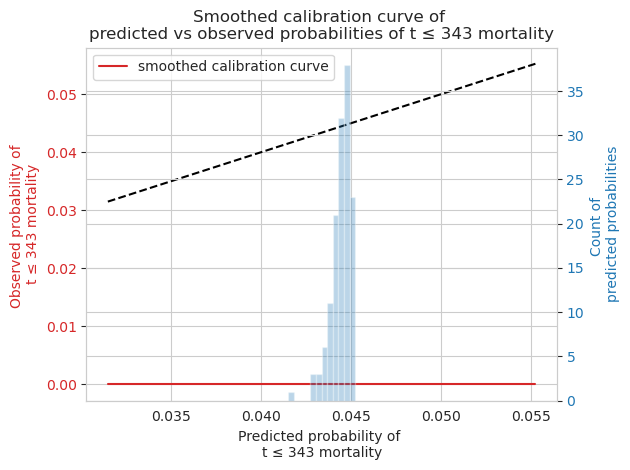

In [214]:
survival_probability_calibration(surv_pred, T_test, E_test, t0=343)

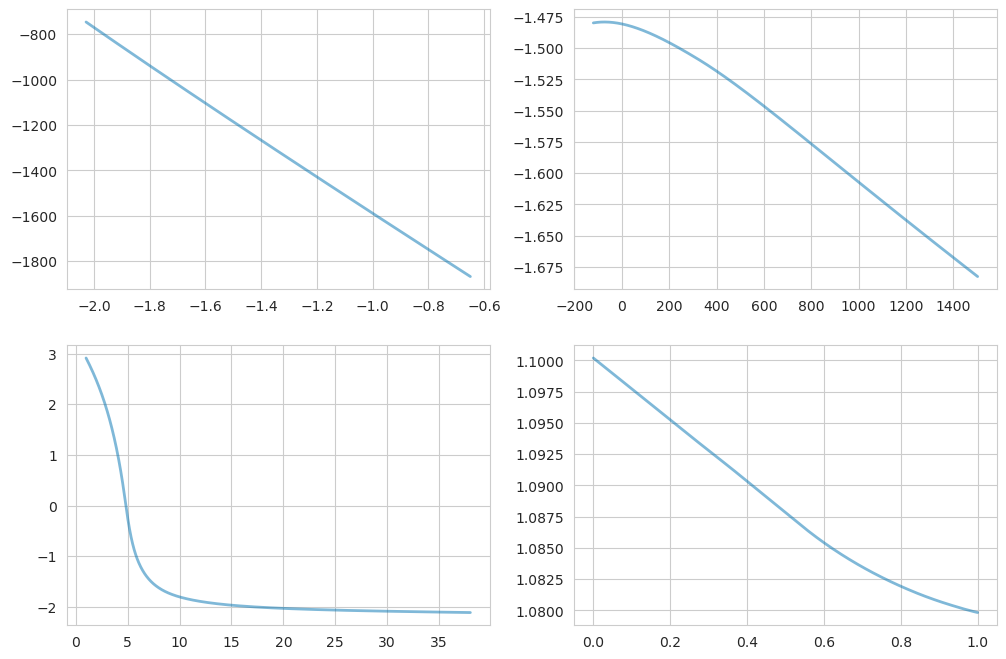

In [215]:
def shape_plot(shape, range_min, range_max):
    shape.to(torch.device('cpu')).eval()
    t = np.linspace(range_min, range_max, 1000)
    with torch.no_grad():
        y = shape(torch.from_numpy(t).float()).numpy().flatten()
    return (t, y)

n_shapes = len(esr_best._program.model.shape_functions)
ranges = esr_best.get_shape_ranges(pd.DataFrame(X_test, columns=feature_names))

fix, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

for i, shape in enumerate(esr_best._program.model.shape_functions):
    t, y = shape_plot(shape, ranges[i][0], ranges[i][1])
    ax[i].plot(t, y, linewidth=2.0, alpha=0.5)
